In [ ]:
import os
print("Please upload your kaggle.json file from Kaggle (My Account > API > Create New Token)")
from google.colab import files
uploaded = files.upload()

if "kaggle.json" in uploaded:
    print("kaggle.json found!")
    os.system("mkdir -p ~/.kaggle")
    os.system("mv /content/kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")
    print("Kaggle API configured.")
else:
    print("Error: kaggle.json not uploaded.")


Please upload your kaggle.json file from Kaggle (My Account > API > Create New Token)


Saving kaggle.json to kaggle.json
kaggle.json found!
Kaggle API configured.


In [ ]:
import os, shutil, time, glob

# 1) Config
FULL_DATA_DIR_BASE = "/content/full_dataset"
DEFAULT_FULL_DATA_DIR = "/content/full_dataset/Dataset"
MINI_DATA_DIR = "/content/mini_dataset"
SAMPLE_FRACTION = 0.05   # ✅ First 5%
SPLITS = ['Train', 'Validation', 'Test']
CLASSES = ['Fake', 'Real']

def create_mini_dataset_first_fraction(source_base, dest_base, fraction):
    """
    Copies the FIRST `fraction` of files (by sorted filename) from each split/class
    to a new destination directory structure.

    Expected source structure:
      source_base/
        ├── Train/
        ├── Validation/
        └── Test/
            ├── Fake/
            └── Real/
    """
    if os.path.exists(dest_base):
        print(f"--- Removing old mini-dataset at {dest_base} ---")
        shutil.rmtree(dest_base)

    print(f"--- Creating new FIRST {int(fraction*100)}% mini-dataset at {dest_base} ---")
    start_time = time.time()
    total_files_copied = 0

    for split in SPLITS:
        print(f"\nProcessing '{split}' split...")
        source_split_dir = os.path.join(source_base, split)
        dest_split_dir = os.path.join(dest_base, split)

        if not os.path.exists(source_split_dir):
            print(f"  WARNING: Source split not found, skipping: {source_split_dir}")
            continue

        for class_name in CLASSES:
            source_class_dir = os.path.join(source_split_dir, class_name)
            dest_class_dir = os.path.join(dest_split_dir, class_name)

            if not os.path.exists(source_class_dir):
                print(f"  WARNING: Source class not found, skipping: {source_class_dir}")
                continue

            os.makedirs(dest_class_dir, exist_ok=True)

            try:
                # Deterministic order: take the FIRST N after sorting by filename
                all_files = sorted(
                    f for f in os.listdir(source_class_dir)
                    if os.path.isfile(os.path.join(source_class_dir, f))
                )
            except Exception as e:
                print(f"  Error listing files in {source_class_dir}: {e}")
                continue

            if not all_files:
                print(f"  No files in {source_class_dir}, skipping.")
                continue

            num_total = len(all_files)
            num_to_take = max(1, int(num_total * fraction))
            selected_files = all_files[:num_to_take]

            print(f"  Copying first {len(selected_files)}/{num_total} from {split}/{class_name} ...")

            for file_name in selected_files:
                src_path = os.path.join(source_class_dir, file_name)
                dst_path = os.path.join(dest_class_dir, file_name)
                shutil.copy(src_path, dst_path)

            total_files_copied += len(selected_files)

    elapsed = time.time() - start_time
    print(f"\n--- ✅ Mini-dataset created successfully. ---")
    print(f"Total files copied: {total_files_copied}")
    print(f"Time taken: {elapsed:.2f} seconds.")

# 2) Download + unzip
try:
    print("--- 1. Downloading dataset from Kaggle... ---")
    os.system("kaggle datasets download -d manjilkarki/deepfake-and-real-images")

    print("\n--- 2. Unzipping dataset... ---")
    os.system(f"mkdir -p {FULL_DATA_DIR_BASE}")
    os.system(f"unzip -q deepfake-and-real-images.zip -d {FULL_DATA_DIR_BASE}")
    os.system("rm deepfake-and-real-images.zip")

    # 3) Auto-detect the actual root that contains 'Train'
    full_dir_candidates = []
    if os.path.isdir(os.path.join(DEFAULT_FULL_DATA_DIR, 'Train')):
        full_dir_candidates = [DEFAULT_FULL_DATA_DIR]
    else:
        candidates = [p for p in glob.glob(f"{FULL_DATA_DIR_BASE}/**/Train", recursive=True)
                      if os.path.isdir(p)]
        full_dir_candidates = sorted(list(set(os.path.dirname(p) for p in candidates)))

    if not full_dir_candidates:
        raise FileNotFoundError(
            "Could not find a 'Train' folder anywhere under /content/full_dataset.\n"
            "Tip: run this to inspect:\n!ls -R /content/full_dataset | head -200"
        )

    FULL_DATA_DIR = full_dir_candidates[0]
    print(f"✅ Using FULL_DATA_DIR = {FULL_DATA_DIR}")

    # 4) Check required splits
    missing = [s for s in SPLITS if not os.path.isdir(os.path.join(FULL_DATA_DIR, s))]
    if missing:
        raise FileNotFoundError(
            "Missing required split folders: " + ", ".join(missing) +
            f"\nLooked under: {FULL_DATA_DIR}"
        )

    # 5) Build the FIRST-5% mini-dataset
    create_mini_dataset_first_fraction(FULL_DATA_DIR, MINI_DATA_DIR, SAMPLE_FRACTION)

    # Quick peek
    os.system(f"echo '\n--- Mini dataset tree (top level) ---'")
    os.system(f"ls -la {MINI_DATA_DIR}")
    for s in SPLITS:
        os.system(f"echo '\n{s}/:' && ls -la {os.path.join(MINI_DATA_DIR, s)}")

except Exception as e:
    print(f"❌ An error occurred during the process: {e}")


--- 1. Downloading dataset from Kaggle... ---

--- 2. Unzipping dataset... ---
✅ Using FULL_DATA_DIR = /content/full_dataset/Dataset
--- Creating new FIRST 5% mini-dataset at /content/mini_dataset ---

Processing 'Train' split...
  Copying first 3500/70001 from Train/Fake ...
  Copying first 3500/70001 from Train/Real ...

Processing 'Validation' split...
  Copying first 982/19641 from Validation/Fake ...
  Copying first 989/19787 from Validation/Real ...

Processing 'Test' split...
  Copying first 274/5492 from Test/Fake ...
  Copying first 270/5413 from Test/Real ...

--- ✅ Mini-dataset created successfully. ---
Total files copied: 9515
Time taken: 1.74 seconds.


In [ ]:
# --- COMMON SETUP (run once) ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, GlobalAveragePooling2D, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom,
                                     RandomTranslation, RandomContrast)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB2, EfficientNetB4, ResNet50V2, Xception
)
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnetv2_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

# Mixed precision (optional)
print("--- ⚡ Enabling Mixed Precision ---")
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Compute dtype:', policy.compute_dtype, '| Variable dtype:', policy.variable_dtype)
except Exception as e:
    print("Mixed precision not enabled:", e)

# Paths to your 25% mini-dataset (created in Cell 2)
TRAIN_DIR = '/content/mini_dataset/Train'
VALID_DIR = '/content/mini_dataset/Validation'
TEST_DIR  = '/content/mini_dataset/Test'
CLASS_NAMES = ['Fake', 'Real']
AUTOTUNE = tf.data.AUTOTUNE

def plot_history(history, title):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.title(title); plt.xlabel("Epochs"); plt.ylabel("Metric")
    plt.grid(True); plt.show()

def create_datasets(img_size, batch_size):
    """Create tf.data datasets from the 25% mini-dataset on disk."""
    print(f"Creating datasets @ {img_size} | batch={batch_size}")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, label_mode='binary', image_size=img_size,
        batch_size=batch_size, shuffle=True)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VALID_DIR, label_mode='binary', image_size=img_size,
        batch_size=batch_size, shuffle=False)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, label_mode='binary', image_size=img_size,
        batch_size=batch_size, shuffle=False)

    # Throughput
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)
    return train_ds, val_ds, test_ds

def build_model(model_fn, preprocess_fn, input_shape, base_name):
    """
    Build model with nested base_model (no input_tensor) so we can unfreeze later.
    Returns (model, base_model).
    """
    print(f"Building: {base_name} | input_shape={input_shape}")
    aug = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(0.1, 0.1),
        RandomContrast(0.1),
    ], name="data_augmentation")

    inputs = Input(shape=input_shape, name="input_layer")
    x = aug(inputs)
    x = preprocess_fn(x)

    base_model = model_fn(include_top=False, weights='imagenet',
                          input_shape=input_shape, name=base_name)
    base_model.trainable = False
    x = base_model(x, training=False)

    x = GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = Dropout(0.5, name="head_dropout")(x)
    outputs = Dense(1, activation='sigmoid', dtype='float32', name="output_layer")(x)

    model = Model(inputs, outputs, name=f"{base_name}_binary_classifier")
    return model, base_model

def evaluate_on_test(model, test_ds, model_name):
    """Evaluate and plot confusion matrix."""
    y_true, y_prob = [], []
    for images, labels in test_ds.as_numpy_iterator():
        y_true.extend(labels)
        y_prob.extend(model.predict(images, verbose=0))
    y_true = np.array(y_true).astype(int)
    y_pred = (np.array(y_prob) > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'{model_name} | Test Acc: {acc*100:.2f}%')
    plt.ylabel('True'); plt.xlabel('Pred'); plt.show()
    return acc


--- ⚡ Enabling Mixed Precision ---
Compute dtype: float16 | Variable dtype: float32


In [ ]:
MODEL_NAME = "EfficientNetB0"
IMG_SIZE = (224, 224)
BATCH = 32

train_ds, val_ds, test_ds = create_datasets(IMG_SIZE, BATCH)
model_b0, base_b0 = build_model(EfficientNetB0, eff_preprocess, IMG_SIZE + (3,), "efficientnetb0")


Creating datasets @ (224, 224) | batch=32
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Building: efficientnetb0 | input_shape=(224, 224, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 89s 252ms/step - accuracy: 0.6946 - loss: 0.5724 - precision: 0.6887 - recall: 0.7233 - val_accuracy: 0.6692 - val_loss: 0.6111 - val_precision: 0.6427 - val_recall: 0.7674
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8177 - loss: 0.4362 - precision: 0.8184 - recall: 0.8183 - val_accuracy: 0.6961 - val_loss: 0.5868 - val_precision: 0.6729 - val_recall: 0.7674
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8234 - loss: 0.4118 - precision: 0.8259 - recall: 0.8214 - val_accuracy: 0.7169 - val_loss: 0.5575 - val_precision: 0.7070 - val_recall: 0.7442
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8398 - loss: 0.3865 - precision: 0.8394 - recall: 0.8420 - val_accuracy: 0.7245 - val_loss: 0.5521 - val_precision: 0.7266 - val_recall: 0.7230
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8289 - loss: 0.3894 - precision: 0.8284 - recall: 0.8313 - val_accuracy: 0.7362 - v

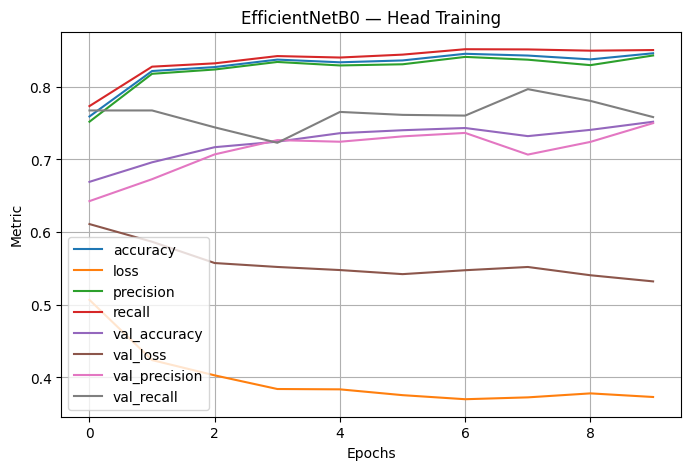

In [ ]:
b0_head_path = "b0_head.keras"

model_b0.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_b0_head = model_b0.fit(
    train_ds, epochs=10, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint(b0_head_path, monitor='val_accuracy', mode='max', save_best_only=True),
    ]
)
plot_history(hist_b0_head, f"{MODEL_NAME} — Head Training")


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 185s 434ms/step - accuracy: 0.8595 - loss: 0.3390 - precision: 0.8544 - recall: 0.8679 - val_accuracy: 0.7960 - val_loss: 0.4716 - val_precision: 0.8236 - val_recall: 0.7553 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.8927 - loss: 0.2724 - precision: 0.8881 - recall: 0.8995 - val_accuracy: 0.8138 - val_loss: 0.4385 - val_precision: 0.8702 - val_recall: 0.7391 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.9005 - loss: 0.2464 - precision: 0.8942 - recall: 0.9092 - val_accuracy: 0.8336 - val_loss: 0.4012 - val_precision: 0.8968 - val_recall: 0.7553 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.9194 - loss: 0.2007 - precision: 0.9147 - recall: 0.9256 - val_accuracy: 0.8447 - val_loss: 0.3811 - val_precision: 0.9119 - val_recall: 0.7644 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━

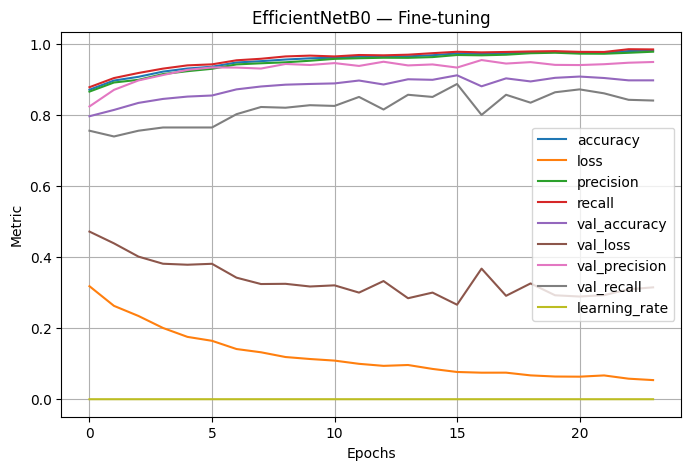

In [ ]:
b0_final_path = "b0_final.keras"

model_b0.load_weights(b0_head_path)
base_b0.trainable = True
for layer in base_b0.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model_b0.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_b0_ft = model_b0.fit(
    train_ds, epochs=30, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True),
        ModelCheckpoint(b0_final_path, monitor='val_accuracy', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)
plot_history(hist_b0_ft, f"{MODEL_NAME} — Fine-tuning")



Classification Report:
              precision    recall  f1-score   support

        Fake       0.88      0.91      0.89       274
        Real       0.90      0.87      0.89       270

    accuracy                           0.89       544
   macro avg       0.89      0.89      0.89       544
weighted avg       0.89      0.89      0.89       544



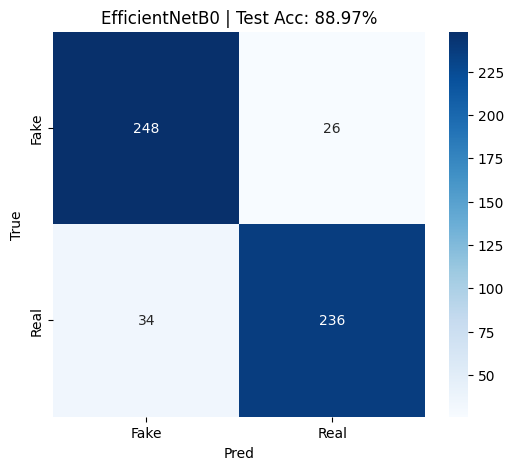

Test Accuracy (B0): 88.97%


In [ ]:
model_b0.load_weights(b0_final_path)
acc_b0 = evaluate_on_test(model_b0, test_ds, MODEL_NAME)
print("Test Accuracy (B0):", f"{acc_b0*100:.2f}%")


In [ ]:
##MODEL_NAME = "EfficientNetB2"



In [ ]:
MODEL_NAME = "EfficientNetB2"
IMG_SIZE = (260, 260)
BATCH = 32

train_ds, val_ds, test_ds = create_datasets(IMG_SIZE, BATCH)
model_b2, base_b2 = build_model(EfficientNetB2, eff_preprocess, IMG_SIZE + (3,), "efficientnetb2")


Creating datasets @ (260, 260) | batch=32
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Building: efficientnetb2 | input_shape=(260, 260, 3)
31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 104s 311ms/step - accuracy: 0.6876 - loss: 0.5866 - precision: 0.6906 - recall: 0.6948 - val_accuracy: 0.6479 - val_loss: 0.6371 - val_precision: 0.6085 - val_recall: 0.8362
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.8217 - loss: 0.4278 - precision: 0.8270 - recall: 0.8185 - val_accuracy: 0.6915 - val_loss: 0.5867 - val_precision: 0.6586 - val_recall: 0.7998
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.8394 - loss: 0.3937 - precision: 0.8463 - recall: 0.8340 - val_accuracy: 0.7108 - val_loss: 0.5711 - val_precision: 0.6730 - val_recall: 0.8241
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.8298 - loss: 0.3890 - precision: 0.8368 - recall: 0.8243 - val_accuracy: 0.7149 - val_loss: 0.5687 - val_precision: 0.6760 - val_recall: 0.8291
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8411 - loss: 0.3777 - precision: 0.8454 - recall: 0.8392 - val_accuracy: 0.6986

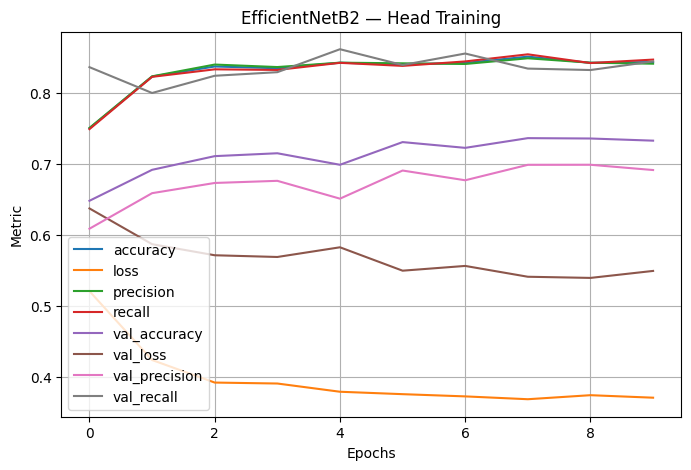

In [ ]:
b2_head_path = "b2_head.keras"

model_b2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_b2_head = model_b2.fit(
    train_ds, epochs=10, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint(b2_head_path, monitor='val_accuracy', mode='max', save_best_only=True),
    ]
)
plot_history(hist_b2_head, f"{MODEL_NAME} — Head Training")


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 248s 609ms/step - accuracy: 0.8565 - loss: 0.3461 - precision: 0.8559 - recall: 0.8615 - val_accuracy: 0.7950 - val_loss: 0.4565 - val_precision: 0.7546 - val_recall: 0.8766 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 233ms/step - accuracy: 0.9103 - loss: 0.2426 - precision: 0.9063 - recall: 0.9174 - val_accuracy: 0.8356 - val_loss: 0.3883 - val_precision: 0.8176 - val_recall: 0.8655 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 233ms/step - accuracy: 0.9291 - loss: 0.1888 - precision: 0.9230 - recall: 0.9381 - val_accuracy: 0.8574 - val_loss: 0.3433 - val_precision: 0.8526 - val_recall: 0.8655 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 233ms/step - accuracy: 0.9425 - loss: 0.1581 - precision: 0.9397 - recall: 0.9472 - val_accuracy: 0.8696 - val_loss: 0.3178 - val_precision: 0.8547 - val_recall: 0.8918 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━

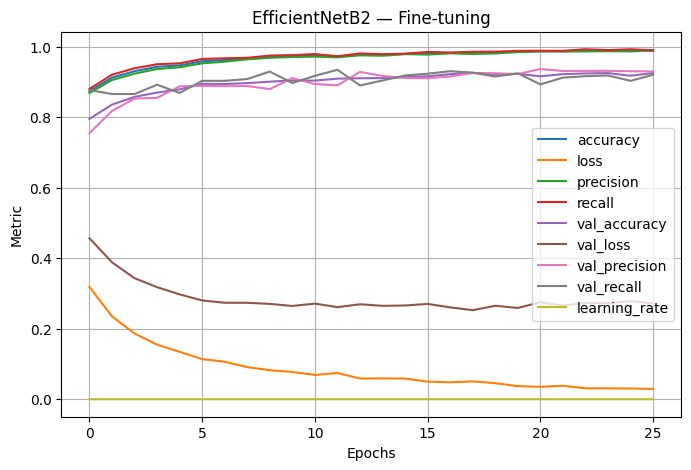

In [ ]:
b2_final_path = "b2_final.keras"

model_b2.load_weights(b2_head_path)
base_b2.trainable = True
for layer in base_b2.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model_b2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_b2_ft = model_b2.fit(
    train_ds, epochs=30, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True),
        ModelCheckpoint(b2_final_path, monitor='val_accuracy', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)
plot_history(hist_b2_ft, f"{MODEL_NAME} — Fine-tuning")



Classification Report:
              precision    recall  f1-score   support

        Fake       0.90      0.89      0.90       274
        Real       0.89      0.90      0.89       270

    accuracy                           0.90       544
   macro avg       0.90      0.90      0.90       544
weighted avg       0.90      0.90      0.90       544



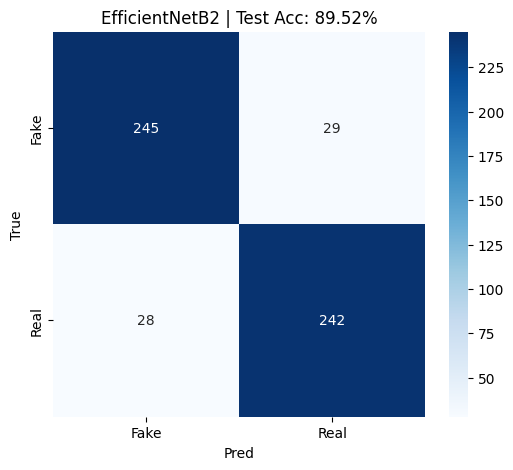

Test Accuracy (B2): 89.52%


In [ ]:
model_b2.load_weights(b2_final_path)
acc_b2 = evaluate_on_test(model_b2, test_ds, MODEL_NAME)
print("Test Accuracy (B2):", f"{acc_b2*100:.2f}%")


In [ ]:
#ResNet50V2

In [ ]:
MODEL_NAME = "ResNet50V2"
IMG_SIZE = (224, 224)
BATCH = 32

train_ds, val_ds, test_ds = create_datasets(IMG_SIZE, BATCH)
model_rn, base_rn = build_model(ResNet50V2, resnetv2_preprocess, IMG_SIZE + (3,), "resnet50v2")


Creating datasets @ (224, 224) | batch=32
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Building: resnet50v2 | input_shape=(224, 224, 3)
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.6912 - loss: 0.6117 - precision: 0.6953 - recall: 0.6930 - val_accuracy: 0.6941 - val_loss: 0.6070 - val_precision: 0.6373 - val_recall: 0.9060
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8365 - loss: 0.3945 - precision: 0.8380 - recall: 0.8381 - val_accuracy: 0.7108 - val_loss: 0.5736 - val_precision: 0.6528 - val_recall: 0.9050
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8596 - loss: 0.3535 - precision: 0.8594 - recall: 0.8633 - val_accuracy: 0.7331 - val_loss: 0.5398 - val_precision: 0.6760 - val_recall: 0.8989
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8523 - loss: 0.3558 - precision: 0.8495 - recall: 0.8598 - val_accuracy: 0.7179 - val_loss: 0.5828 - val_precision: 0.6534 - val_recall: 0.9323
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8572 - loss: 0.3387 - precision: 0.8574 - recall: 0.8604 - val_accuracy: 0.7281 - va

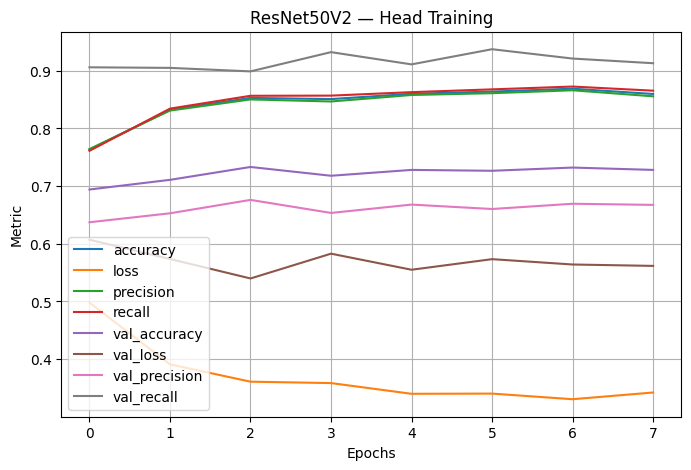

In [ ]:
rn_head_path = "resnet_head.keras"

model_rn.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_rn_head = model_rn.fit(
    train_ds, epochs=10, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint(rn_head_path, monitor='val_accuracy', mode='max', save_best_only=True),
    ]
)
plot_history(hist_rn_head, f"{MODEL_NAME} — Head Training")


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 83s 208ms/step - accuracy: 0.8767 - loss: 0.3109 - precision: 0.8756 - recall: 0.8815 - val_accuracy: 0.8574 - val_loss: 0.3451 - val_precision: 0.8605 - val_recall: 0.8544 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.9200 - loss: 0.2050 - precision: 0.9153 - recall: 0.9274 - val_accuracy: 0.8808 - val_loss: 0.2925 - val_precision: 0.8985 - val_recall: 0.8595 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.9461 - loss: 0.1504 - precision: 0.9386 - recall: 0.9558 - val_accuracy: 0.8914 - val_loss: 0.2810 - val_precision: 0.9291 - val_recall: 0.8483 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.9502 - loss: 0.1247 - precision: 0.9477 - recall: 0.9541 - val_accuracy: 0.9006 - val_loss: 0.2602 - val_precision: 0.9314 - val_recall: 0.8655 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━

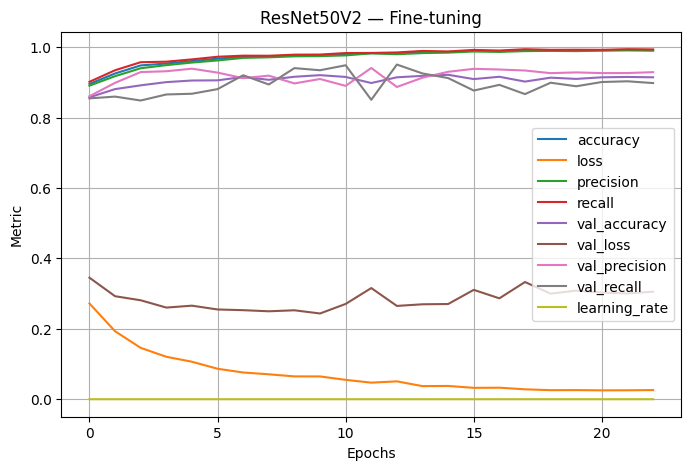

In [ ]:
rn_final_path = "resnet_final.keras"

model_rn.load_weights(rn_head_path)
base_rn.trainable = True
for layer in base_rn.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model_rn.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_rn_ft = model_rn.fit(
    train_ds, epochs=30, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True),
        ModelCheckpoint(rn_final_path, monitor='val_accuracy', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)
plot_history(hist_rn_ft, f"{MODEL_NAME} — Fine-tuning")



Classification Report:
              precision    recall  f1-score   support

        Fake       0.90      0.89      0.90       274
        Real       0.89      0.90      0.90       270

    accuracy                           0.90       544
   macro avg       0.90      0.90      0.90       544
weighted avg       0.90      0.90      0.90       544



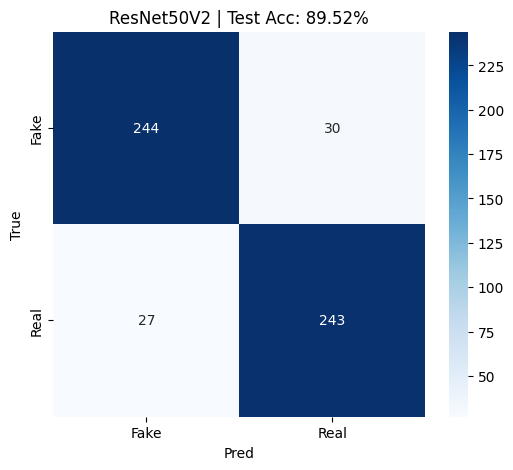

Test Accuracy (ResNet50V2): 89.52%


In [ ]:
model_rn.load_weights(rn_final_path)
acc_rn = evaluate_on_test(model_rn, test_ds, MODEL_NAME)
print("Test Accuracy (ResNet50V2):", f"{acc_rn*100:.2f}%")


In [ ]:
#EfficientNetB4

In [ ]:
MODEL_NAME = "EfficientNetB4"
IMG_SIZE = (380, 380)
BATCH = 16  # heavier model

train_ds, val_ds, test_ds = create_datasets(IMG_SIZE, BATCH)
model_b4, base_b4 = build_model(EfficientNetB4, eff_preprocess, IMG_SIZE + (3,), "efficientnetb4")


Creating datasets @ (380, 380) | batch=16
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Building: efficientnetb4 | input_shape=(380, 380, 3)
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 163s 275ms/step - accuracy: 0.7172 - loss: 0.5481 - precision: 0.7241 - recall: 0.6913 - val_accuracy: 0.6722 - val_loss: 0.6172 - val_precision: 0.6416 - val_recall: 0.7856
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - accuracy: 0.8265 - loss: 0.4082 - precision: 0.8280 - recall: 0.8209 - val_accuracy: 0.6880 - val_loss: 0.6046 - val_precision: 0.6553 - val_recall: 0.7978
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - accuracy: 0.8461 - loss: 0.3714 - precision: 0.8435 - recall: 0.8471 - val_accuracy: 0.7174 - val_loss: 0.5720 - val_precision: 0.6957 - val_recall: 0.7765
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 77s 175ms/step - accuracy: 0.8447 - loss: 0.3594 - precision: 0.8415 - recall: 0.8471 - val_accuracy: 0.7047 - val_loss: 0.5895 - val_precision: 0.6697 - val_recall: 0.8119
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - accuracy: 0.8467 - loss: 0.3635 - precision: 0.8409 - recall: 0.8523 - val_accuracy: 0.724

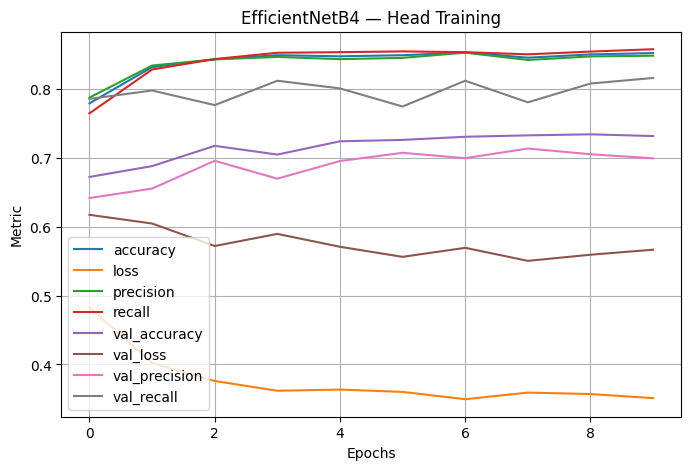

In [ ]:
b4_head_path = "b4_head.keras"

model_b4.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_b4_head = model_b4.fit(
    train_ds, epochs=10, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint(b4_head_path, monitor='val_accuracy', mode='max', save_best_only=True),
    ]
)
plot_history(hist_b4_head, f"{MODEL_NAME} — Head Training")


Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 401s 615ms/step - accuracy: 0.8742 - loss: 0.3031 - precision: 0.8713 - recall: 0.8756 - val_accuracy: 0.8341 - val_loss: 0.3928 - val_precision: 0.8271 - val_recall: 0.8463 - learning_rate: 1.0000e-05
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 186s 424ms/step - accuracy: 0.9297 - loss: 0.1807 - precision: 0.9212 - recall: 0.9387 - val_accuracy: 0.8813 - val_loss: 0.3206 - val_precision: 0.8986 - val_recall: 0.8605 - learning_rate: 1.0000e-05
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 186s 424ms/step - accuracy: 0.9515 - loss: 0.1271 - precision: 0.9478 - recall: 0.9548 - val_accuracy: 0.8960 - val_loss: 0.2884 - val_precision: 0.8866 - val_recall: 0.9090 - learning_rate: 1.0000e-05
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 186s 424ms/step - accuracy: 0.9656 - loss: 0.0920 - precision: 0.9611 - recall: 0.9699 - val_accuracy: 0.9127 - val_loss: 0.2631 - val_precision: 0.9130 - val_recall: 0.9130 - learning_rate: 1.0000e-05
Epoch 5/30
438/438 ━━━━━━━━━━━━━

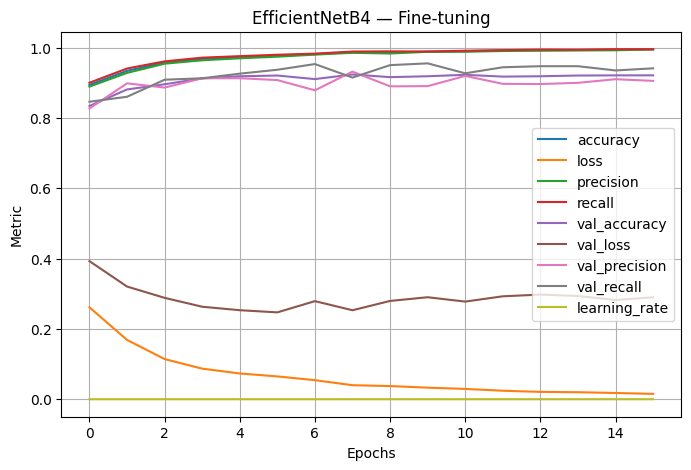

In [ ]:
b4_final_path = "b4_final.keras"

model_b4.load_weights(b4_head_path)
base_b4.trainable = True
for layer in base_b4.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model_b4.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_b4_ft = model_b4.fit(
    train_ds, epochs=30, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True),
        ModelCheckpoint(b4_final_path, monitor='val_accuracy', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)
plot_history(hist_b4_ft, f"{MODEL_NAME} — Fine-tuning")



Classification Report:
              precision    recall  f1-score   support

        Fake       0.89      0.92      0.90       274
        Real       0.92      0.89      0.90       270

    accuracy                           0.90       544
   macro avg       0.90      0.90      0.90       544
weighted avg       0.90      0.90      0.90       544



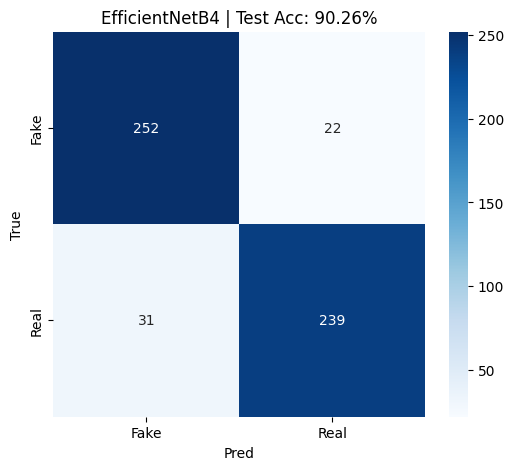

Test Accuracy (B4): 90.26%


In [ ]:
model_b4.load_weights(b4_final_path)
acc_b4 = evaluate_on_test(model_b4, test_ds, MODEL_NAME)
print("Test Accuracy (B4):", f"{acc_b4*100:.2f}%")


In [ ]:
#xception

In [ ]:
MODEL_NAME = "Xception"
IMG_SIZE = (299, 299)   # native for Xception
BATCH = 32

train_ds, val_ds, test_ds = create_datasets(IMG_SIZE, BATCH)
model_xc, base_xc = build_model(Xception, xception_preprocess, IMG_SIZE + (3,), "xception")


Creating datasets @ (299, 299) | batch=32
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Building: xception | input_shape=(299, 299, 3)
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 252ms/step - accuracy: 0.6882 - loss: 0.5976 - precision: 0.6895 - recall: 0.6598 - val_accuracy: 0.6408 - val_loss: 0.6508 - val_precision: 0.5994 - val_recall: 0.8564
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.7941 - loss: 0.4649 - precision: 0.7820 - recall: 0.8080 - val_accuracy: 0.6601 - val_loss: 0.6354 - val_precision: 0.6140 - val_recall: 0.8686
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - accuracy: 0.8113 - loss: 0.4398 - precision: 0.8069 - recall: 0.8114 - val_accuracy: 0.6682 - val_loss: 0.6268 - val_precision: 0.6209 - val_recall: 0.8696
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.8099 - loss: 0.4242 - precision: 0.8013 - recall: 0.8178 - val_accuracy: 0.6859 - val_loss: 0.6108 - val_precision: 0.6389 - val_recall: 0.8605
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.8138 - loss: 0.4147 - precision: 0.8061 - recall: 0.8199 - val_accuracy: 0.6900

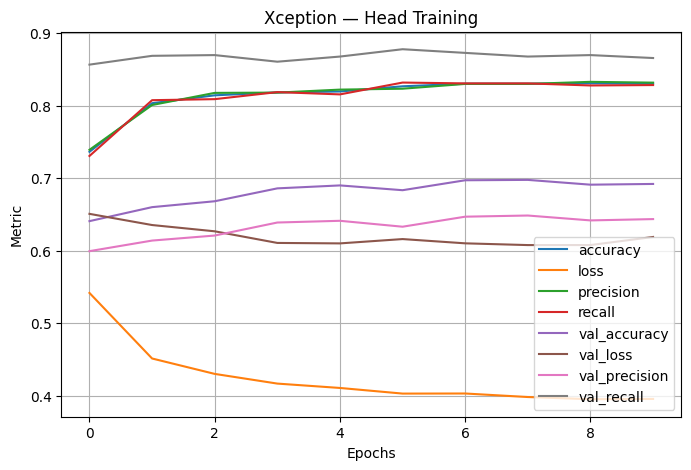

In [ ]:
xc_head_path = "xception_head.keras"

model_xc.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_xc_head = model_xc.fit(
    train_ds, epochs=10, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint(xc_head_path, monitor='val_accuracy', mode='max', save_best_only=True),
    ]
)
plot_history(hist_xc_head, f"{MODEL_NAME} — Head Training")


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 211s 584ms/step - accuracy: 0.8599 - loss: 0.3363 - precision: 0.8610 - recall: 0.8526 - val_accuracy: 0.7484 - val_loss: 0.5421 - val_precision: 0.6795 - val_recall: 0.9434 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.9225 - loss: 0.2055 - precision: 0.9147 - recall: 0.9293 - val_accuracy: 0.8148 - val_loss: 0.4434 - val_precision: 0.7464 - val_recall: 0.9555 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.9486 - loss: 0.1417 - precision: 0.9437 - recall: 0.9525 - val_accuracy: 0.8767 - val_loss: 0.3165 - val_precision: 0.8342 - val_recall: 0.9414 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.9528 - loss: 0.1193 - precision: 0.9458 - recall: 0.9593 - val_accuracy: 0.9046 - val_loss: 0.2809 - val_precision: 0.8719 - val_recall: 0.9494 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━

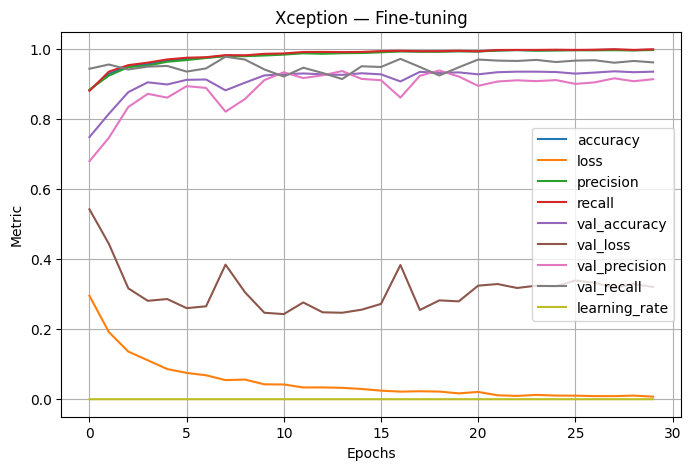

In [ ]:
xc_final_path = "xception_final.keras"

model_xc.load_weights(xc_head_path)
base_xc.trainable = True
for layer in base_xc.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model_xc.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
hist_xc_ft = model_xc.fit(
    train_ds, epochs=30, validation_data=val_ds,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True),
        ModelCheckpoint(xc_final_path, monitor='val_accuracy', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    ]
)
plot_history(hist_xc_ft, f"{MODEL_NAME} — Fine-tuning")



Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.85      0.90       274
        Real       0.87      0.96      0.91       270

    accuracy                           0.90       544
   macro avg       0.91      0.90      0.90       544
weighted avg       0.91      0.90      0.90       544



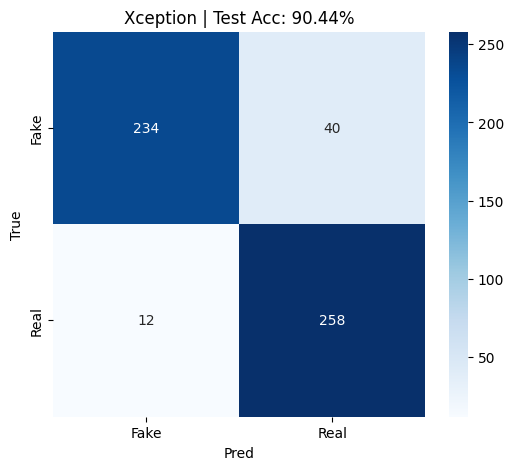

Test Accuracy (Xception): 90.44%


In [ ]:
model_xc.load_weights(xc_final_path)
acc_xc = evaluate_on_test(model_xc, test_ds, MODEL_NAME)
print("Test Accuracy (Xception):", f"{acc_xc*100:.2f}%")


In [ ]:
#sir code

Found 7000 images belonging to 2 classes.
Found 1971 images belonging to 2 classes.
Found 544 images belonging to 2 classes.
Class indices: {'Fake': 0, 'Real': 1}
Class weights: {0: 1.0, 1: 1.0}


Model: "ForenResLite"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │        448 │ input[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        160 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │        272 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ add_12[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │        160 │ re_lu_2[0][0]     │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │        544 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │        544 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ conv2d_6[0][0]  

 Total params: 68,785 (268.69 KB)

 Trainable params: 66,673 (260.44 KB)

 Non-trainable params: 2,112 (8.25 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 307s 888ms/step - accuracy: 0.6533 - loss: 0.6173 - val_accuracy: 0.5226 - val_loss: 0.6924
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - accuracy: 0.7856 - loss: 0.4664 - val_accuracy: 0.5535 - val_loss: 0.8061
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 333ms/step - accuracy: 0.8190 - loss: 0.4112 - val_accuracy: 0.5601 - val_loss: 1.1026
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 335ms/step - accuracy: 0.8547 - loss: 0.3500 - val_accuracy: 0.6210 - val_loss: 0.8987
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - accuracy: 0.8545 - loss: 0.3427 - val_accuracy: 0.6296 - val_loss: 0.7295
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 332ms/step - accuracy: 0.8780 - loss: 0.3036 - val_accuracy: 0.6585 - val_loss: 0.6409
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - accuracy: 0.8770 - loss: 0.2936 - val_accuracy: 0.7007 - val_loss: 0.6624
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 333ms/step - accuracy: 0.8868 - loss: 

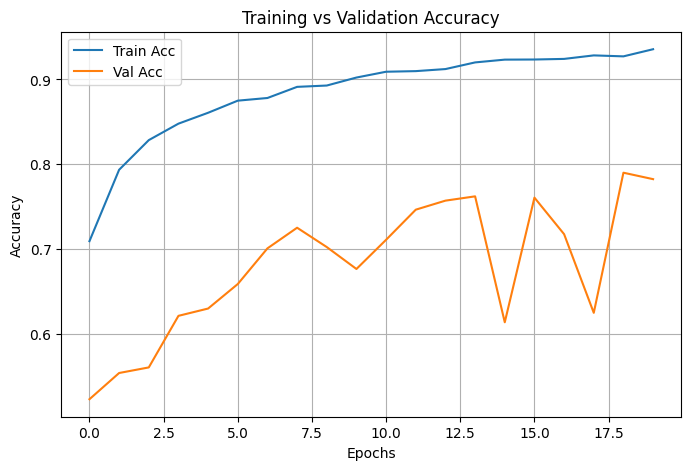

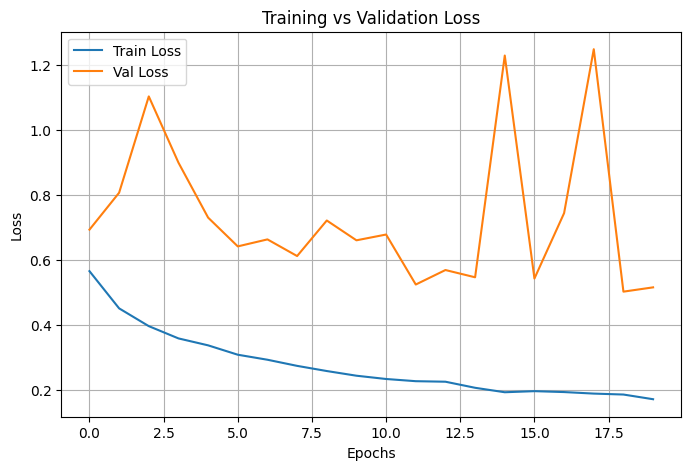

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7478 - loss: 0.6203
Test Accuracy: 0.7812

Confusion Matrix:
 [[183  91]
 [ 28 242]]


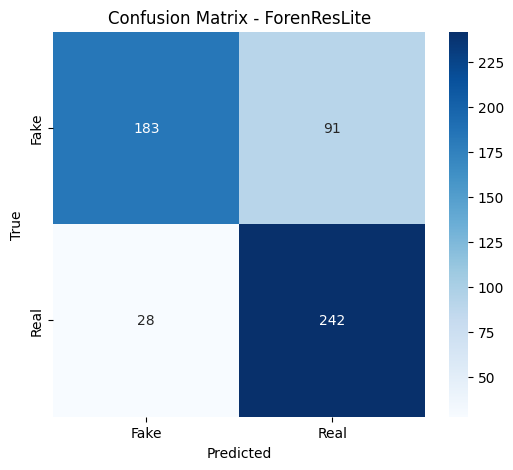


Classification Report:
              precision    recall  f1-score   support

        Fake       0.87      0.67      0.75       274
        Real       0.73      0.90      0.80       270

    accuracy                           0.78       544
   macro avg       0.80      0.78      0.78       544
weighted avg       0.80      0.78      0.78       544


Precision: 0.7267 | Recall: 0.8963 | F1: 0.8027


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization,
    ReLU, Add, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# ----------------------------
# Paths (created by your Cell 2)
# ----------------------------
TRAIN_DIR = '/content/mini_dataset/Train'
VAL_DIR   = '/content/mini_dataset/Validation'
TEST_DIR  = '/content/mini_dataset/Test'

# ----------------------------
# Model definition (binary)
# ----------------------------
def depthwise_res_block(x, filters, stride=1):
    """Depthwise Separable Convolution + Residual"""
    shortcut = x
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    out = Add()([x, shortcut])
    out = ReLU()(out)
    return out

def foren_reslite(input_shape=(224, 224, 3)):
    """Custom lightweight CNN for Fake vs Real (binary)"""
    inp = Input(shape=input_shape, name="input")
    # Stem
    x = Conv2D(16, (3,3), strides=2, padding='same')(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Depthwise Blocks
    x = depthwise_res_block(x, 16)
    x = depthwise_res_block(x, 32, stride=2)
    x = depthwise_res_block(x, 32)
    x = depthwise_res_block(x, 64, stride=2)
    x = depthwise_res_block(x, 64)
    x = depthwise_res_block(x, 128, stride=2)
    x = depthwise_res_block(x, 128)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='sigmoid', name="output")(x)  # binary

    return Model(inputs=inp, outputs=out, name="ForenResLite")

# ----------------------------
# Data (ImageDataGenerator)
# ----------------------------
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 20

# Augmentation for train; only rescale for val/test
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    fill_mode='nearest'
)
val_gen   = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

# IMPORTANT: binary class mode; directory names must be 'Fake' and 'Real'
train_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=True
)
val_data = val_gen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)
test_data = test_gen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='binary', shuffle=False
)

print("Class indices:", train_data.class_indices)  # e.g., {'Fake': 0, 'Real': 1}

# ----------------------------
# Optional: handle imbalance
# ----------------------------
# Compute simple class weights from train set counts
train_counts = Counter(train_data.classes)  # dict: {0: n_fake, 1: n_real}
total = sum(train_counts.values())
class_weight = {
    0: total / (2.0 * train_counts.get(0, 1)),
    1: total / (2.0 * train_counts.get(1, 1))
}
print("Class weights:", class_weight)

# ----------------------------
# Build & train
# ----------------------------
model = foren_reslite(input_shape=IMG_SIZE + (3,))
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

ckpt_head = "ForenResLite_head.keras"
callbacks_head = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
    ModelCheckpoint(ckpt_head, monitor='val_accuracy', mode='max', save_best_only=True),
]

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    class_weight=class_weight,
    callbacks=callbacks_head,
    verbose=1
)

# ----------------------------
# Fine-tuning tip (optional):
# This model is small; if you want to fine-tune more, you could
# unfreeze BatchNorm layers or add L2/Dropout above. For now we keep it simple.
# ----------------------------

# Save final (in modern Keras format)
final_path = "ForenResLite_final.keras"
model.save(final_path)
print(f"✅ Model saved as {final_path}")

# ----------------------------
# Plots
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy'); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss'); plt.grid(True); plt.show()

# ----------------------------
# Test evaluation
# ----------------------------
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
probs = model.predict(test_data, verbose=0).ravel()  # shape (N,)
pred_classes = (probs > 0.5).astype(int)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  # ['Fake','Real'] (order matches indices)

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix - ForenResLite'); plt.show()

# Classification Report + metrics
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Dynamic averaging (binary)
precision = precision_score(true_classes, pred_classes, average='binary')
recall = recall_score(true_classes, pred_classes, average='binary')
f1 = f1_score(true_classes, pred_classes, average='binary')
print(f"\nPrecision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")


In [ ]:
# ============================================================
# CELL 2 — Face-aligned cropping to 299 (MTCNN; fallback center-crop)
# ============================================================
!pip -q install mtcnn pillow

import os, glob, time, numpy as np, tensorflow as tf
from mtcnn.mtcnn import MTCNN
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

# ---- Config / seeds ----
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ---- Source (must exist from Cell 1) ----
# Your mini dataset should be here: /content/mini_dataset/{Train,Validation,Test}/{Fake,Real}
DATA_ROOT = "/content/mini_dataset"
assert os.path.isdir(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}. Build the mini dataset first."

# Discover class names from the Train split (expects exactly two classes)
train_split = os.path.join(DATA_ROOT, "Train")
assert os.path.isdir(train_split), f"Train split not found at {train_split}"
CLASS_NAMES = sorted([d for d in os.listdir(train_split) if os.path.isdir(os.path.join(train_split, d))])
assert len(CLASS_NAMES) == 2, f"Expected 2 classes, found: {CLASS_NAMES}"

# ---- Destination for cropped set ----
CROP_ROOT = "/content/mini_dataset_face299"
os.makedirs(CROP_ROOT, exist_ok=True)

# ---- MTCNN face cropper with fallback ----
_detector = None  # lazy init

def crop_face_from_image(src_path, dst_path, target=299):
    global _detector
    try:
        img = Image.open(src_path).convert("RGB")
    except Exception:
        return  # skip unreadable

    try:
        arr = np.array(img)
        if _detector is None:
            _detector = MTCNN()
        dets = _detector.detect_faces(arr)

        if dets:
            x, y, w, h = dets[0]["box"]
            x, y = max(0, x), max(0, y)
            face = img.crop((x, y, x + max(1, w), y + max(1, h)))
        else:
            # fallback: center-crop shortest side
            s = min(img.width, img.height)
            left = (img.width - s) // 2
            top = (img.height - s) // 2
            face = img.crop((left, top, left + s, top + s))

        face = face.resize((target, target), Image.BILINEAR)
    except Exception:
        # if detection/resizing fails, fallback to simple resize
        face = img.resize((target, target), Image.BILINEAR)

    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    face.save(dst_path, quality=95)

# ---- Mirror the original structure and crop ----
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def is_image(p):
    ext = os.path.splitext(p)[1].lower()
    return ext in IMG_EXTS

t0 = time.time()
for split in ["Train", "Validation", "Test"]:
    src_split = os.path.join(DATA_ROOT, split)
    if not os.path.isdir(src_split):
        print(f"Skipping missing split: {src_split}")
        continue

    # pick classes present in this split to be robust
    classes_here = [d for d in os.listdir(src_split) if os.path.isdir(os.path.join(src_split, d))]
    # if nothing discovered, fall back to CLASS_NAMES
    if not classes_here:
        classes_here = CLASS_NAMES

    for cls in classes_here:
        src_dir = os.path.join(src_split, cls)
        dst_dir = os.path.join(CROP_ROOT, split, cls)
        os.makedirs(dst_dir, exist_ok=True)

        files = [p for p in glob.glob(os.path.join(src_dir, "*")) if is_image(p)]
        for p in files:
            dst = os.path.join(dst_dir, os.path.basename(p))
            if not os.path.exists(dst):
                crop_face_from_image(p, dst, target=299)
        print(f"[{split}/{cls}] -> cropped {len(files)} images.")

print(f"✅ Face-cropped dataset built at: {CROP_ROOT} in {time.time()-t0:.1f}s")

# ---- Dataloaders @299 ----
F_TRAIN_DIR = f"{CROP_ROOT}/Train"
F_VAL_DIR   = f"{CROP_ROOT}/Validation"
F_TEST_DIR  = f"{CROP_ROOT}/Test"

def make_face_datasets(image_size=(299, 299), batch_size=32, augment=True, seed=SEED):
    def preprocess(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomContrast(0.05),
    ])

    def with_aug(x, y):
        return aug(x, training=True), y

    train = tf.keras.utils.image_dataset_from_directory(
        F_TRAIN_DIR, label_mode="binary",
        image_size=image_size, batch_size=batch_size,
        shuffle=True, seed=seed
    )
    val = tf.keras.utils.image_dataset_from_directory(
        F_VAL_DIR, label_mode="binary",
        image_size=image_size, batch_size=batch_size,
        shuffle=False
    )
    test = tf.keras.utils.image_dataset_from_directory(
        F_TEST_DIR, label_mode="binary",
        image_size=image_size, batch_size=batch_size,
        shuffle=False
    )

    train = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
    val   = val.map(preprocess,   num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
    test  = test.map(preprocess,  num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

    if augment:
        train = train.map(with_aug, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train, val, test

face_train, face_val, face_test = make_face_datasets((299, 299), 32, augment=True)

# ---- Quick sanity training with Xception head-frozen ----
base = tf.keras.applications.Xception(
    include_top=False, weights="imagenet", input_shape=(299, 299, 3)
)
base.trainable = False  # head training only

inputs = layers.Input((299, 299, 3))
# Xception expects [-1, 1] input scaling
x = (inputs - 0.5) * 2.0
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

m_face = keras.Model(inputs, outputs, name="xception_face299_head")
m_face.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss="binary_crossentropy",
               metrics=["accuracy"])

print("Starting a short sanity fit (2 epochs) to verify pipeline...")
m_face.fit(face_train, epochs=2, validation_data=face_val)
print("✅ Sanity run complete.")


[Train/Real] -> cropped 3500 images.
[Train/Fake] -> cropped 3500 images.
[Validation/Real] -> cropped 989 images.
[Validation/Fake] -> cropped 982 images.
[Test/Real] -> cropped 270 images.
[Test/Fake] -> cropped 274 images.
✅ Face-cropped dataset built at: /content/mini_dataset_face299 in 350.7s
Found 7000 files belonging to 2 classes.
Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.
Starting a short sanity fit (2 epochs) to verify pipeline...
Epoch 1/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 187s 643ms/step - accuracy: 0.6681 - loss: 0.5923 - val_accuracy: 0.6733 - val_loss: 0.6101
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - accuracy: 0.8201 - loss: 0.4282 - val_accuracy: 0.6961 - val_loss: 0.5901
✅ Sanity run complete.


In [ ]:
# ============================================================
# CELL 3 — TTA inference (returns probs averaged over transforms)
# ============================================================
def tta_batch(images):
    # images in [0,1]; map to [-1,1] for Xception inside the model call itself
    # We'll create 8 variants: id, hflip, small rot/zoom/shift/contrast combos via tf.image
    outs = []
    outs.append(images)  # identity
    outs.append(tf.image.flip_left_right(images))
    def rot(imgs, deg): # nearest transforms
        rad = deg * math.pi/180.0
        return tfa.image.rotate(imgs, rad, fill_mode='reflect')
    def bright(imgs, delta): return tf.image.adjust_brightness(imgs, delta)
    def cont(imgs, fac):    return tf.image.adjust_contrast(imgs, fac)

    try:
        import tensorflow_addons as tfa
        outs.append(rot(images, 3))
        outs.append(rot(images, -3))
    except:
        # fallback: no rotate if tfa not available
        pass
    outs.append(bright(images,  0.05))
    outs.append(bright(images, -0.05))
    outs.append(cont(images, 1.05))
    outs.append(cont(images, 0.95))
    return outs[:8]

def predict_with_tta(model, ds, max_views=8):
    all_probs = []
    for x, _ in ds:
        views = tta_batch(x)
        views = views[:max_views]
        probs = [ model.predict(v, verbose=0).astype("float32").ravel() for v in views ]
        probs = np.stack(probs, axis=0).mean(axis=0)
        all_probs.extend(probs.tolist())
    return np.array(all_probs)

# Example usage after training a model `m_face`:
# tta_probs = predict_with_tta(m_face, face_test, max_views=6)
# y_true = np.concatenate([y.numpy().ravel() for _,y in face_test], axis=0).astype(int)
# print("TTA sample probs:", tta_probs[:5])


In [ ]:
# ============================================================
# CELL 4 — Threshold tuning on validation (maximize Youden's J)
# ============================================================
def best_threshold_from_val(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    youden = tpr - fpr
    i = np.argmax(youden)
    return float(thr[i]), float(tpr[i]), float(fpr[i])

def collect_probs(model, ds):
    y_true, y_prob = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0).astype("float32").ravel()
        y_true.extend(y.numpy().ravel().tolist())
        y_prob.extend(p.tolist())
    return np.array(y_true).astype(int), np.array(y_prob)

# Example (after you trained m_face)
# vy, vp = collect_probs(m_face, face_val)
# thr, tpr, fpr = best_threshold_from_val(vy, vp)
# print("Best threshold:", thr)
# evaluate_and_report(m_face, face_test, threshold=thr, name="Xception FaceCrop299 + ThrTune")


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.7159 - loss: 0.5790 - val_accuracy: 0.8006 - val_loss: 0.4544 - learning_rate: 1.0000e-05
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.9331 - loss: 0.2566 - val_accuracy: 0.8869 - val_loss: 0.3212 - learning_rate: 1.0000e-05
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.9646 - loss: 0.2003 - val_accuracy: 0.9041 - val_loss: 0.2942 - learning_rate: 1.0000e-05
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.9711 - loss: 0.1804 - val_accuracy: 0.9127 - val_loss: 0.2870 - learning_rate: 1.0000e-05
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.9782 - loss: 0.1687 - val_accuracy: 0.9178 - val_loss: 0.2754 - learning_rate: 1.0000e-05
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.9875 - loss: 0.1544 - val_accuracy: 0.9244 - val_loss: 0.2714 - learning_rate: 1.0000e-05
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 175m

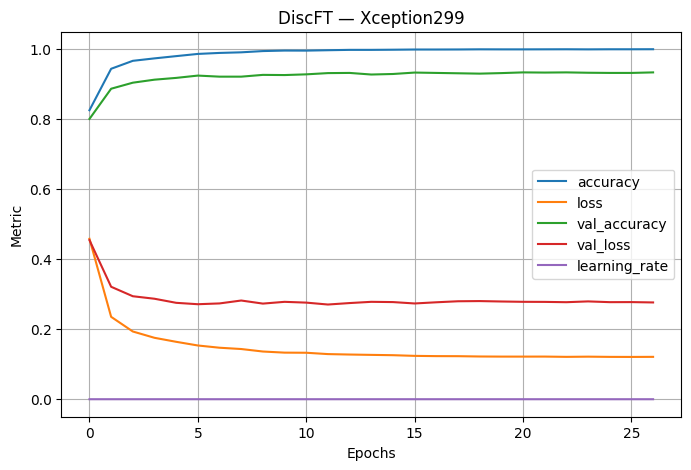

NameError: name 'roc_curve' is not defined

In [ ]:
# ============================================================
# CELL 5 — DiscFT: AdamW + Label Smoothing, BN frozen
# ============================================================
def freeze_batchnorm(model):
    for l in model.layers:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False

def build_xception_299(train_base=True, wd=1e-5, label_smooth=0.05):
    base = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(299,299,3))
    base.trainable = train_base
    inputs = layers.Input((299,299,3))
    x = (inputs - 0.5)*2.0
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
    model = keras.Model(inputs, outputs)
    loss = keras.losses.BinaryCrossentropy(label_smoothing=label_smooth)
    opt  = keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=wd)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    freeze_batchnorm(model)
    return model

# Train from face datasets (already created in Cell 2)
disc_model = build_xception_299(train_base=True, wd=1e-5, label_smooth=0.05)
ckpt = keras.callbacks.ModelCheckpoint("x_discft.keras", monitor="val_accuracy", save_best_only=True, mode="max")
rlr  = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.2, patience=3, min_lr=1e-7, verbose=1)
es   = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, mode="max", restore_best_weights=True)
hist = disc_model.fit(face_train, epochs=30, validation_data=face_val, callbacks=[ckpt, rlr, es])
plot_history(hist, "DiscFT — Xception299")

# Eval default and with tuned threshold
vy, vp = collect_probs(disc_model, face_val)
best_thr, _, _ = best_threshold_from_val(vy, vp)
print("Best threshold from validation:", best_thr)
_ = evaluate_and_report(disc_model, face_test, threshold=0.5,     name="DiscFT Xception299 (thr=0.5)")
_ = evaluate_and_report(disc_model, face_test, threshold=best_thr, name="DiscFT Xception299 (thr=tuned)")


In [ ]:
# ===== EVAL-0: imports + helpers (no tensorflow-addons needed) =====
import os, math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, precision_recall_fscore_support, brier_score_loss
)

tf.random.set_seed(42); np.random.seed(42)

# Paths (edit if needed)
F_VAL_DIR   = "/content/mini_dataset_face299/Validation"
F_TEST_DIR  = "/content/mini_dataset_face299/Test"
IMG_SIZE    = 299
BATCH       = 32


# ---------- Dataset ----------
def make_ds(dir_path, image_size=(IMG_SIZE, IMG_SIZE), batch=BATCH, shuffle=False):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path, label_mode="binary", image_size=image_size,
        batch_size=batch, shuffle=shuffle
    )
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(tf.data.AUTOTUNE)

VAL_DS  = make_ds(F_VAL_DIR,  shuffle=False)
TEST_DS = make_ds(F_TEST_DIR, shuffle=False)


# ---------- Helpers ----------
def collect_probs(model, ds):
    y_true, y_prob = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0).ravel()
        y_true.extend(y.numpy().ravel().astype(int).tolist())
        y_prob.extend(p.tolist())
    return np.array(y_true), np.array(y_prob)


def best_threshold_from_val(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return float(thr[np.argmax(j)])


def evaluate_and_report(y_true, y_prob, threshold=0.5, name="Model"):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_true, y_prob)
    bs  = brier_score_loss(y_true, y_prob)

    print(f"\n=== {name} (thr={threshold:.3f}) ===")
    print(f"Acc: {acc:.4f} | Prec: {pr:.4f} | Rec: {rc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f} | Brier: {bs:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Fake","Real"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion — {name}")
    plt.xticks([0,1], ["Fake","Real"]); plt.yticks([0,1],["Fake","Real"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha='center', va='center')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar()
    plt.show()


Found 1971 files belonging to 2 classes.
Found 544 files belonging to 2 classes.


In [ ]:
# ===== EVAL-1: TTA (no rotations) =====
def _tta_views(images):
    return [
        images,
        tf.image.flip_left_right(images),
        tf.image.adjust_brightness(images,  0.05),
        tf.image.adjust_brightness(images, -0.05),
        tf.image.adjust_contrast(images, 1.10),
        tf.image.adjust_contrast(images, 0.90),
    ]  # 6 variants


def predict_with_tta(model, ds):
    y_true, y_prob = [], []
    for x, y in ds:
        views = _tta_views(x)
        # predict all views
        probs = [model.predict(v, verbose=0).ravel() for v in views]
        # average predictions
        p = np.stack(probs, axis=0).mean(axis=0)
        y_true.extend(y.numpy().ravel().astype(int).tolist())
        y_prob.extend(p.tolist())
    return np.array(y_true), np.array(y_prob)


In [ ]:
# ===== EVAL-2: load trained model WITHOUT compiling =====
CKPT_PATH = "x_discft.keras"   # change if filename differs
assert os.path.exists(CKPT_PATH), "Checkpoint file not found!"

disc_model = tf.keras.models.load_model(CKPT_PATH, compile=False)
disc_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

Best validation threshold: 0.5020091533660889

=== DiscFT Xception299 (thr=0.5) (thr=0.500) ===
Acc: 0.9246 | Prec: 0.9046 | Rec: 0.9481 | F1: 0.9259 | AUC: 0.9649 | Brier: 0.0635
              precision    recall  f1-score   support

        Fake       0.95      0.90      0.92       274
        Real       0.90      0.95      0.93       270

    accuracy                           0.92       544
   macro avg       0.93      0.92      0.92       544
weighted avg       0.93      0.92      0.92       544



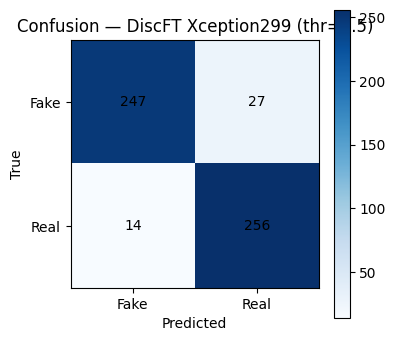


=== DiscFT Xception299 (thr=tuned) (thr=0.502) ===
Acc: 0.9246 | Prec: 0.9046 | Rec: 0.9481 | F1: 0.9259 | AUC: 0.9649 | Brier: 0.0635
              precision    recall  f1-score   support

        Fake       0.95      0.90      0.92       274
        Real       0.90      0.95      0.93       270

    accuracy                           0.92       544
   macro avg       0.93      0.92      0.92       544
weighted avg       0.93      0.92      0.92       544



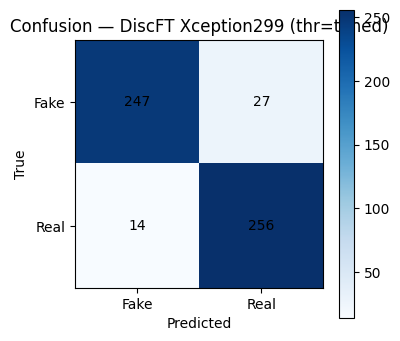


=== DiscFT Xception299 (thr=tuned + TTA) (thr=0.502) ===
Acc: 0.9246 | Prec: 0.9046 | Rec: 0.9481 | F1: 0.9259 | AUC: 0.9654 | Brier: 0.0621
              precision    recall  f1-score   support

        Fake       0.95      0.90      0.92       274
        Real       0.90      0.95      0.93       270

    accuracy                           0.92       544
   macro avg       0.93      0.92      0.92       544
weighted avg       0.93      0.92      0.92       544



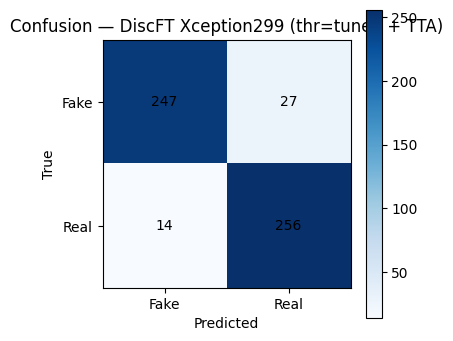

In [ ]:
# ===== EVAL-3: Validate threshold + Test =====

# 1) threshold from VALIDATION
vy, vp = collect_probs(disc_model, VAL_DS)
best_thr = best_threshold_from_val(vy, vp)
print("Best validation threshold:", best_thr)

# 2) TEST — plain
ty, tp = collect_probs(disc_model, TEST_DS)
evaluate_and_report(ty, tp, threshold=0.5,     name="DiscFT Xception299 (thr=0.5)")
evaluate_and_report(ty, tp, threshold=best_thr, name="DiscFT Xception299 (thr=tuned)")

# 3) TEST — TTA
tty, ttp = predict_with_tta(disc_model, TEST_DS)
evaluate_and_report(tty, ttp, threshold=best_thr, name="DiscFT Xception299 (thr=tuned + TTA)")


In [ ]:
# ============================================================
# CELL 6 — MixUp augmentation (can be combined with others)
# ============================================================
def mixup_pairs(x1, y1, x2, y2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

def make_mixup_dataset(ds, alpha=0.2):
    ds1 = ds.unbatch().batch(1)
    ds2 = ds.unbatch().batch(1).shuffle(10*BATCH, seed=SEED)
    ds_mix = tf.data.Dataset.zip((ds1, ds2))
    def _mix(a, b):
        (x1,y1) = a; (x2,y2) = b
        x = tf.cast(x1, tf.float32); x2 = tf.cast(x2, tf.float32)
        y = tf.cast(y1, tf.float32); y2 = tf.cast(y2, tf.float32)
        lam = tfp.distributions.Beta(alpha, alpha).sample((1,))
        x_m = lam * x + (1.0 - lam) * x2
        y_m = lam * y + (1.0 - lam) * y2
        return tf.squeeze(x_m, axis=0), tf.squeeze(y_m, axis=0)
    try:
        import tensorflow_probability as tfp
        ds_mix = ds_mix.map(_mix, num_parallel_calls=tf.data.AUTOTUNE)
    except:
        # fallback: python-side numpy mixing (slower)
        def _mix_np(a, b):
            (x1,y1) = a; (x2,y2) = b
            x1=x1.numpy(); y1=y1.numpy(); x2=x2.numpy(); y2=y2.numpy()
            xm, ym = mixup_pairs(x1, y1, x2, y2, alpha=alpha)
            return xm, ym
        ds_mix = ds_mix.map(lambda a,b: tf.numpy_function(_mix_np, [a,b], [tf.float32, tf.float32]),
                            num_parallel_calls=tf.data.AUTOTUNE)
    return ds_mix.batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Example usage:
# mx_train = make_mixup_dataset(face_train)
# disc_model_mix = build_xception_299(train_base=True, wd=1e-5, label_smooth=0.05)
# disc_model_mix.fit(mx_train, epochs=10, validation_data=face_val)
